# Radial Velocity of Galaxy NGC7531
**DATA INFO.** The galaxy data frame records the radial velocity of a spiral galaxy measured at 323 points in the area of sky which it covers. All the measurements lie within seven slots crossing at the origin. The positions of the measurements given by four variables (columns).

Variables:

|               |                                                       |
|---------------|-------------------------------------------------------|
|east.west      |The east-west coordinate. The origin, (0,0), is near <br/>the center of the galaxy, east is negative, west is positive.|
|north.south    |The north-south coordinate. The origin, (0,0), is near<br/> the center of the galaxy, south is negative, north is positive.|
|angle          |Degrees of counter-clockwise rotation from the horizontal <br/>of the slot within which the observation lies.|
|radial.position|Signed distance from origin; negative if east-west coordinate<br/> is negative.|
|velocity       |Radial velocity measured in km/sec.|

SOURCE:<br/>
Buta, R. (1987) The Structure and Dynamics of Ringed Galaxies, III: Surface Photometry and Kinematics of the Ringed Nonbarred Spiral NGC7531. The Astrophysical J. Supplement Ser. Vol. 64, pp. 1--37.

John M. Chambers and Trevor J. Hastie, (eds.) Statistical Models in S, Wadsworth and Brooks, Pacific Grove, CA 1992, pg. 352.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import transforms, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

%matplotlib inline

# set common plots properties
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
# define commonly used colors
GRAY3, GRAY7 = '#555655', '#929497'

## Load and Prepare Data

In [2]:
# load and prepare data
df = pd.read_csv("../data/Galaxy.txt")
target = 'velocity'
features = ['north.south', 'east.west']
X, y = df[features].values, df[target].values
df.head()

,row.names,east.west,north.south,angle,radial.position,velocity
0,3,8.462789,-38.173172,102.5,39.099998,1769
1,4,7.964978,-35.927692,102.5,36.799999,1749
2,5,7.467167,-33.682213,102.5,34.500001,1749
3,6,6.969356,-31.436731,102.5,32.200000,1758
4,7,6.471544,-29.191250,102.5,29.899999,1750


## Plotting

In [3]:
# prepares 3D plot
def prepare_3d_plot():
    fig = plt.figure(figsize=(4.5, 4.5), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xlabel('South-North', color=GRAY3, fontsize=8)
    ax.set_ylabel('East-West', color=GRAY3, fontsize=8)
    ax.set_zlabel('Velocity', color=GRAY3, fontsize=8)
    ax.w_xaxis.line.set_color(GRAY7)
    ax.w_yaxis.line.set_color(GRAY7)
    ax.w_zaxis.line.set_color(GRAY7)
    ax.view_init(34, -20)
    frame = plt.gca()
    frame.axes.xaxis.set_ticklabels([])
    frame.axes.yaxis.set_ticklabels([])
    frame.axes.zaxis.set_ticklabels([])
    ax.yaxis.labelpad = -15
    ax.xaxis.labelpad = -15
    ax.zaxis.labelpad = -15
    return ax

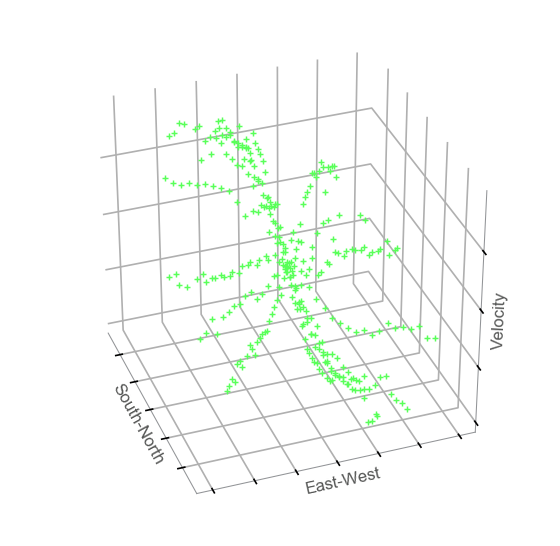

In [4]:
# plot galaxy data, we use -X[:, 1] to be consistend with the book
ax = prepare_3d_plot()
_ = ax.scatter(X[:, 0], -X[:, 1], y, color='#59FF59', marker='+', s=7,
               linewidth=0.7, depthshade=False)

# Local Regression in $R^p$
Scikit-Learn doesn't have local regression implemented. Let's implement it ourselves.

In [5]:
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator

In [6]:
class LocalRegression(BaseEstimator):
    """Local regression model with tri-cube kernel and k-NN bandwidth.
    Parameters
    ----------
        model :
            Underlying model to fit. Should have fit method with weights and
            predict and/or predict_proba methods.
        kernel_size :
            The number or a fraction of nearest points to be in the kernel.
    """
    def __init__(self, model, kernel_size: int=1):
        self.model = model
        self.kernel_size = kernel_size

    def fit(self,
            X: np.ndarray, y: np.array=None) -> 'LocalRegression':
        self.X, self.y = X, y
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        return self.__predict(X, self.model.predict_proba)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.__predict(X, self.model.predict)

    def __predict(self, X: np.ndarray, fnc) -> np.ndarray:
        result = []
        for i in range(X.shape[0]):
            self.model.fit(
                self.X, self.y,
                sample_weight=self.__tri_cube_kernel(X[i:i + 1, :]))
            result.append(np.atleast_2d(fnc([X[i]])))
        return np.vstack(result)

    def __tri_cube_kernel(self, x0):
        points_cnt = self.kernel_size
        if points_cnt <= 1:
            points_cnt = int(self.X.shape[0] * points_cnt)
        distances = cdist(self.X, x0)
        kernel_points_indices = np.argpartition(
            distances, points_cnt, axis=0)[:points_cnt]
        max_distance = np.max(distances[kernel_points_indices])
        relative_distance = distances/max_distance
        result = (relative_distance <= 1)*(1-relative_distance**3)**3
        return np.squeeze(result)

In [7]:
local_regression = LocalRegression(
    model=LinearRegression(), kernel_size=50
).fit(X, y)

In [8]:
# prepare meshgrid for surface and wireframe plotting
X0I, X1I = np.meshgrid(np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 25),
                       np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 25))
y_hat = local_regression.predict(np.vstack((
    np.atleast_2d(X0I.flatten()), np.atleast_2d(X1I.flatten()))).T)
YI = y_hat.reshape((X0I.shape[0], -1))

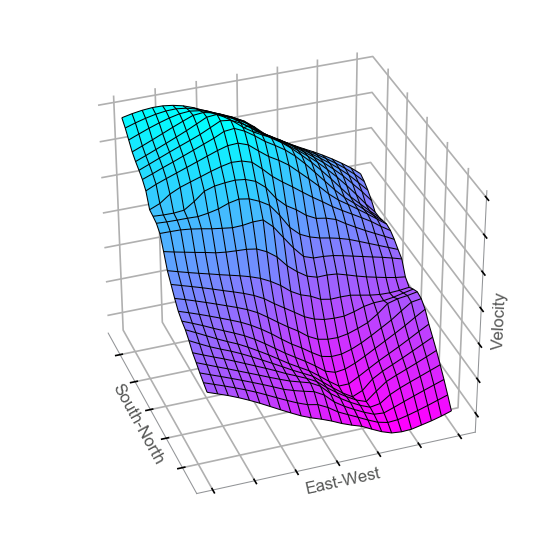

In [9]:
# PAGE 201. FIGURE 6.8. The left panel shows three-dimensional data, where the
#           response is the velocity measurements on a galaxy, and the two
#           predictors record positions on the celestial sphere. The unusual
#           “star”-shaped design indicates the way the measurements were made,
#           and results in an extremely irregular boundary. The right panel
#           shows the results of local linear regression smoothing in R^2,
#           using a nearest-neighbor window with 15% of the data.
# prepare colormap that looks similar to the book's one
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 0, N)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(1, 1, N)
newcmp = ListedColormap(vals)

# PAGE 201. Although the scatter-cloud and wire-frame pictures in Figure 6.8
#           look attractive, it is quite difficult to interpret the results
#           except at a gross level. From a data analysis perspective,
#           conditional plots are far more useful.
ax = prepare_3d_plot()
ax.plot_surface(X0I, -X1I, YI, cmap=newcmp, shade=False)
_ = ax.plot_wireframe(X0I, -X1I, YI, cmap=newcmp, linewidth=0.5, color='black')